# Exercise 3: Advanced Information Retrieval


## 1.  Introducing Word Embeddings

In this exercise, we would train word embeddings using a state-of-the-art embeddings library fastText. The first step of the exercise is to install the fastText library. Proceed with the following steps:

### FastText installation
#### For Linux and Mac

#### Run these commands on the shell terminal:

> wget https://github.com/facebookresearch/fastText/archive/v0.2.0.zip <br>
> unzip v0.2.0.zip<br>
> cd fastText-0.2.0 <br>
> make<br>

<br>

(Use curl -O for mac, or just download and unzip manually by clicking on the link, then switch to the unzipped folder and use the make command.

(If this fails, alternatives are listed here: https://github.com/facebookresearch/fastText)

Move the epfldocs.txt file (provided in the last exercise) to the current directory. Sample command (linux) for copying the file into current directory is as follows:

> cp directory_path/epfldocs.txt ./

(or just drag and drop the file)

<br>

### Generate Embeddings

Further, generate fasttext embeddings for the epfldocs.txt file using the following command:

> ./fasttext skipgram -input epfldocs.txt -output model_epfldocs


The above command generates word embeddings and stores them in a file named model_epfldocs.vec.

<br>

#### For Windows Lovers
The above instructions handle the job without dealing with python interface of fasttext which decreases the further installation problems. However they do not work with Windows, so you have to install python interface. Open Anaconda prompt, activate your environment with activate yourenv, and do the following:

> pip install Cython <br>
> pip install fasttext

(If this fails as well, borrow the model file from your neighbour.) <br>
Then run the code below to create a model. 


In [4]:
import fasttext
fasttext.cbow('epfldocs.txt', 'model_epfldocs')

ImportError: No module named 'fasttext'

### Load Embeddings
In the second phase of this exercise, we will load these embeddings into memory using python and visualize them. <br>
When you create a model with fasttext, two outputs are two files, a '.bin' file which is the model object and a '.vec' file which contains all the word vectors. We will manually load the second to plot all the words in the model. Note that this is problematic for a bigger model because all vectors will not fit into your memory.

Use the following python code to load the embeddings into memory:<br><br>

In [6]:
import sys
import codecs
import numpy as np

# Edit this, or just move model_epfldocs.vec to the directory where this notebook is situated
directory_path = './'

def load_embeddings(file_name):
    with codecs.open(file_name, 'r', 'utf-8') as f_in:
        lines = f_in.readlines()
        lines = lines[1:]
        vocabulary, wv = zip(*[line.strip().split(' ', 1) for line in lines])
    wv = np.loadtxt(wv)
    return wv, vocabulary


# Replace the path based on your own machine.
word_embeddings, vocabulary = load_embeddings(directory_path + 'model_epfldocs.vec')

Note that here we are loading the vectors manually. However you can install python's fasttext interface (https://pypi.org/project/fasttext/) to create, save and load models easier. We omit this approach in this tutorial in order to avoid setting up more libraries, in the interest of time.




### Visualize Embeddings

In the third phase of this exercise, we will visualize the generated embeddings using t-SNE (T-Distributed Stochastic Neighbouring Entities). t-SNE is a dimensionality reduction algorithm which is well suited for such visualization tasks.


In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
import logging

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300) # init='pca'
vis_data = tsne.fit_transform(word_embeddings)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 432 samples in 0.006s...
[t-SNE] Computed neighbors for 432 samples in 0.074s...
[t-SNE] Computed conditional probabilities for sample 432 / 432
[t-SNE] Mean sigma: 0.019348
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.084663
[t-SNE] KL divergence after 300 iterations: 0.362276


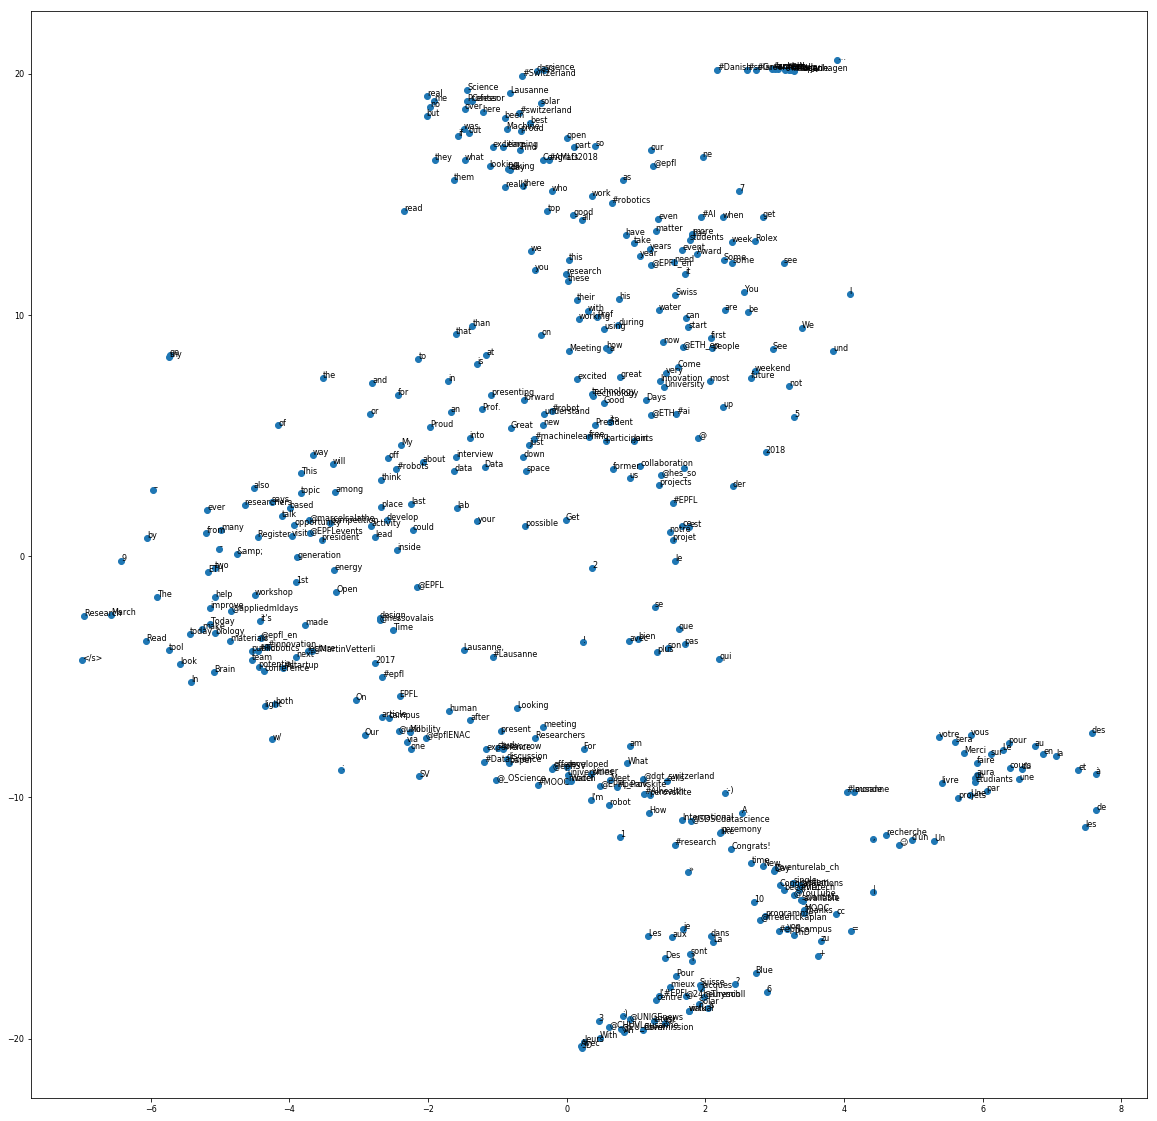

In [8]:
vis_data_x = vis_data[:,0]
vis_data_y = vis_data[:,1]

plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(20, 20)) 
plt.scatter(vis_data_x, vis_data_y)

for label, x, y in zip(vocabulary, vis_data_x, vis_data_y):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

### Question 1. a

Observe the plot of word embeddings. Do you observe any patterns?



### Question 1. b

Write a python function to find the most similar terms for a given term. The similarity between two terms is defined as the cosine similarity between their corresponding word embeddings.

Find the top 3 terms that are most similar to 'la', 'EPFL', '#robot', 'this', 

### Question 1. c [Optional]
​
Download the text file using the following command:
​
> wget http://mattmahoney.net/dc/text8.zip -O text8.gz <br>
> tar -xvf text8.gz 
​
​
The above command creates a text file named 'text8'. Regenerate the fasttext embeddings using the text8 file. Plot the word embeddings for first 1000 terms in the vocabulary.
​
### Question 1. d [Optional]
​
Observe the word embeddings that are visualized in this link http://www.anthonygarvan.com/wordgalaxy/ . Can you make some interesting observations? 

## 2.  Basic Search Engine Using Word Embeddings



In this exercise, we would put our word embeddings to test by using them for information retrieval. 
The idea is that, the documents that have the most similar embedding vectors to the one belongs to query should rank higher.
The documents may not necessarily include the keywords in the query.



In [ ]:
# Loading of libraries and documents
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
from nltk.corpus import stopwords
import math
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')

# Tokenize, stem a document
stemmer = PorterStemmer()
def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    return " ".join([stemmer.stem(word.lower()) for word in tokens])

# Read a list of documents from a file. Each line in a file is a document
with open("epfldocs.txt", ) as f:
    content = f.readlines()
        
original_documents = [x.strip() for x in content] 
documents = [tokenize(d).split() for d in original_documents]

### Question 2. a
Since both the documents and the query is of variable size, we should aggregate the vectors of the words in the query by some strategy. This could be taking the minimum vector, maximum vector or the mean. Fill in the code below.

In [ ]:
# Create a dictionary of vectors for easier search
vector_dict = dict(zip(vocabulary, word_embeddings))

def aggregate_vector_list(vlist, aggfunc):
    if aggfunc == 'max':
        return # TODO
    elif aggfunc == 'min':
        return # TODO 
    elif aggfunc == 'mean':
        return # TODO
    else:
        return np.zeros(np.array(vlist).shape[1])

possible_aggfuncs = ["max", "min", "mean"]

aggregated_doc_vectors = {}

# Aggregate vectors of documents beforehand
# Be sure to tokenize the document with nltk.word_tokenize!
# TODO
for aggfunc in possible_aggfuncs:
    aggregated_doc_vectors[aggfunc] = np.zeros((len(original_documents), word_embeddings.shape[1]))
    for index, doc in enumerate(original_documents):
        vlist = # TODO
        aggregated_doc_vectors[aggfunc][index] = # TODO

### Question 2. b
Aggregate the query and find the most similar documents using cosine distance between the query's vector and document's aggregated vector. Are they seem to relevant?

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

query = "EPFL"

def aggregate_query(query, aggfunc):
    # TODO
    # Raise an error message for the case when there is no words in the query that is included in the vocabulary
    # This should return a vector of shape (1, word_embeddings.shape[1])
    
def get_most_similar_documents(query_vector, aggfunc, k = 5):
    # Calculate the similarity with each document vector. 
    # Hint: Cosine similarity function takes a matrix as input so you do not need to loop through each document vector.
    sim = # TODO
    
    # Rank the document vectors according to their cosine similarity with the query vector and return topk indexes
    indexes = # TODO

    return indexes


def search_vec_embeddings(query, topk = 10, aggfunc = 'mean'):
    query_vector = aggregate_query(query, aggfunc)
    indexes = get_most_similar_documents(query_vector, aggfunc)
    # Print the top k documents
    indexes = indexes[0:topk]
    for index in indexes:
        print(original_documents[index])

In [ ]:
search_vec_embeddings('EPFL', aggfunc = 'mean')

### Question 2. c
Compare the results with the vector space retrieval.


In [ ]:
# VECTOR SPACE RETRIEVAL (From Exercise 1)
# Retrieval oracle 
from operator import itemgetter
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 1, stop_words = 'english')
features = tf.fit_transform(original_documents)
npm_tfidf = features.todense()

# Return all document ids that that have cosine similarity with the query larger than a threshold
def search_vec_sklearn(query, topk = 10, features = features, threshold=0.1):
    new_features = tf.transform([query])
    cosine_similarities = cosine_similarity(new_features, features).flatten()
    related_docs_indices, cos_sim_sorted = zip(*sorted(enumerate(cosine_similarities), key=itemgetter(1), 
                                                       reverse=True))
    doc_ids = []
    for i, cos_sim in enumerate(cos_sim_sorted):
        if cos_sim < threshold or i >= topk:
            break
        doc_ids.append(related_docs_indices[i])
    
    for index in doc_ids:
        print(original_documents[index])

In [ ]:
search_vec_embeddings('EPFL', aggfunc = 'mean')
print("---------------------------------")
search_vec_sklearn("EPFL")

### Question 2. d
You will realize that not all the words in your queries are in the vocabulary, so your queries fail to retrieve any documents. Think of possible solutions to overcome this problem.